## Code Implemented

### Install Required Dependencies

In [2]:
!pip install -r requirements.txt

### Import Libraries

In [1]:
# External imports
import numpy as np
import time
import tdmclient.notebook

# Internal imports
from scripts.vision import Vision
from scripts.global_navigation import GlobalNav
from scripts.local_navigation import LocalNav
from scripts.extended_kalman_filter import ExtendedKalmanFilter
from utils import utils

### General Configuration

In [ ]:
# Time step configuration
DT = 0.1  # s

# Webcam configuration
DEVICE_ID = 2

# World configuration
WORLD_WIDTH = 710  # mm
WORLD_HEIGHT = 360 # mm

# Thymio configuration
THYMIO_WIDTH = 110  # mm
THYMIO_LENGTH = 110  # mm$
THYMIO_WHEEL_BASE = 90  # mm
THYMIO_WHEEL_RADIUS = 20  # mm
SPEED_TO_MM_S = 1.3 # Found experimentally (cf run_tests.ipynb)

# Kidnapping configuration
KIDNAP_THRESHOLD = 40 # mm

### Initialize Classes

In [3]:
vision = Vision(DEVICE_ID)
global_nav = GlobalNav()
local_nav = LocalNav()
ekf = ExtendedKalmanFilter(DT, THYMIO_WHEEL_BASE)

Vision initialized correctly.
GlobalNav initialized correctly.
LocalNav initialized correctly.
EKF initialized correctly.


### Start Thymio

In [4]:
await tdmclient.notebook.start()
print("Successfully connected to Thymio.")

Successfully connected to Thymio.


### Define Thymio Functions

In [5]:
@tdmclient.notebook.sync_var
def set_speed(left,right):
    global motor_left_target, motor_right_target
    motor_left_target = left
    motor_right_target = right
    
@tdmclient.notebook.sync_var
def get_speed():
    global motor_left_speed, motor_right_speed
    return motor_left_speed, motor_right_speed
    
@tdmclient.notebook.sync_var
def motor_stop():
    global motor_left_target,motor_right_target
    motor_left_target = 0
    motor_right_target = 0
    
@tdmclient.notebook.sync_var
def sensor_data():
    global prox_horizontal
    return prox_horizontal.copy()

print("Thymio functions defined correctly.")

Thymio functions defined correctly.


### Test Thymio Functions

In [6]:
set_speed(100, 100)
time.sleep(1)
v_l, v_r = get_speed()
print(f"Current speeds: {v_l}, {v_r}")
motor_stop()

Current speeds: 111, 97


### Test Camera

In [7]:
try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    start_time = time.time()
    while time.time() - start_time < 3:
        original_frame = vision._get_original_frame()
        utils.display_frames(original_frame, None, None)
except KeyboardInterrupt:
    pass
finally:
    vision.disconnect_webcam()

Webcam disconnected correctly.


### Get perspective view, thymio, goal and obstacles position, trajectory planning

Webcam disconnected correctly.

=== Obstacles Information ===
Number of obstacles detected: 1
Obstacle coordinates [mm]:

Obstacle 1:
    Corner 1: [413.5, 132.1]
    Corner 2: [278.1, 138.7]
    Corner 3: [286.0, 237.3]
    Corner 4: [420.1, 230.1]

=== Thymio Information ===
Position [mm]: [57.9, 291.9]
Orientation [°]: 1.5

=== Goal Information ===
Position [mm]: [670.6, 39.4]

=== Trajectory Information ===
Number of waypoints: 2
Waypoint path [mm]:
Checkpoint 1: [181.3, 76.5]
Checkpoint 2: [670.6, 39.4]


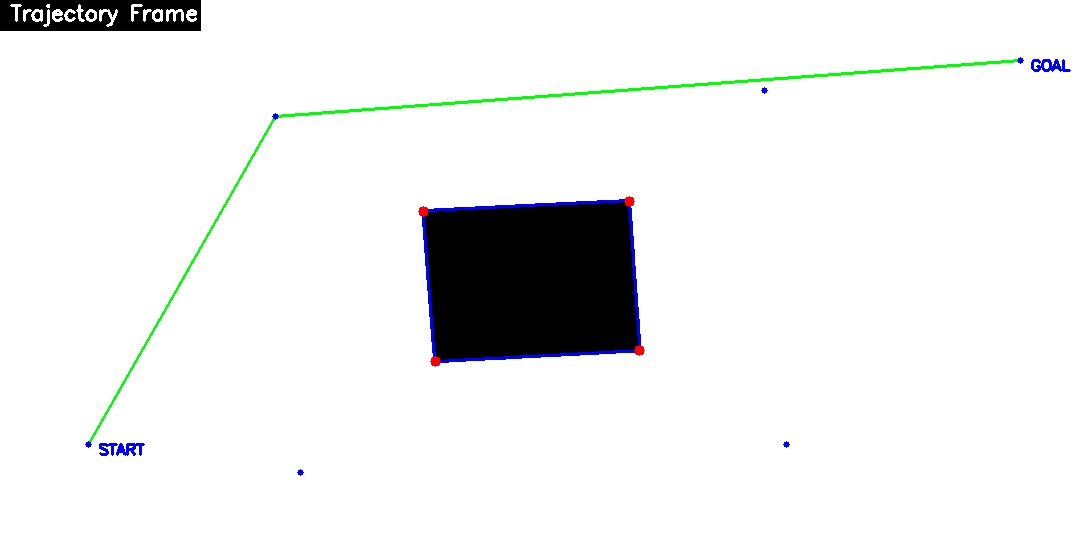

In [8]:
# Display variables
obstacles_img = None
trajectory_frame = None

# Positions variables
thymio_pos = None
goal_pos = None
trajectory_pos = None
obstacles_pos = None

# Flags variables
found_thymio = False
found_goal = False
found_trajectory = False

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
    
    input("Press Enter to calculate the perspective vision...")
    
    # Get the perspective parameters for processing frame and return the scale factor for pixels to mm conversion
    vision.get_perspective_parameters(WORLD_WIDTH, WORLD_HEIGHT)
    
    # Display the original and processed frames
    original_frame, process_frame = vision.get_frame()
    utils.display_frames(original_frame, process_frame, None)
    
    input("Press Enter to get the obstacles position...")
    
    vision.flush()
    # Get the obstacles position
    _, process_frame = vision.get_frame()
    obstacles_pos, obstacles_img = vision.get_obstacles_position(process_frame)
    
    input("Press Enter when thymio and goal position have been placed on the map...")
    
    vision.flush()
    # Get the goal position and thymio position
    while not found_thymio:
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        time.sleep(DT)
    
    print("Thymio detected!")
    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
    
    vision.flush()
    while not found_goal:
        _, process_frame = vision.get_frame()
        frame, goal_pos, found_goal = vision.get_goal_position(process_frame)
        time.sleep(DT)
    print("Goal detected!")
    print(f"Goal position [mm]: {np.round(goal_pos, 1)}")
    
    utils.display_frames(None, frame, None)
    
    input("Press Enter to get the trajectory from thymio to goal position...")
    
    vision.flush()
    # Get the trajectory from thymio to goal position
    while not found_trajectory:
        _, frame = vision.get_frame()
        trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                       THYMIO_WIDTH, vision.scale_factor)    
        time.sleep(DT)
         
    # Initialize the EKF
    ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0])) # x, y, theta, v, omega
    ekf.set_mode(covered=False) # Set the mode to uncovered
    
    utils.display_frames(None, frame, trajectory_frame)
    
    input("Press Enter to get overall information...")
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
except KeyboardInterrupt:
    print("User interrupted the kernel. Closing the webcam...")

finally:
    # Release resources
    vision.disconnect_webcam()
    utils.print_status(obstacles_pos, thymio_pos, goal_pos, trajectory_pos)
    utils.display_frames(None, None, trajectory_frame)
    

Webcam disconnected correctly.
Finished at time [s]: 26.400000000000002
Camera coverage [%]: 18.181818181818183


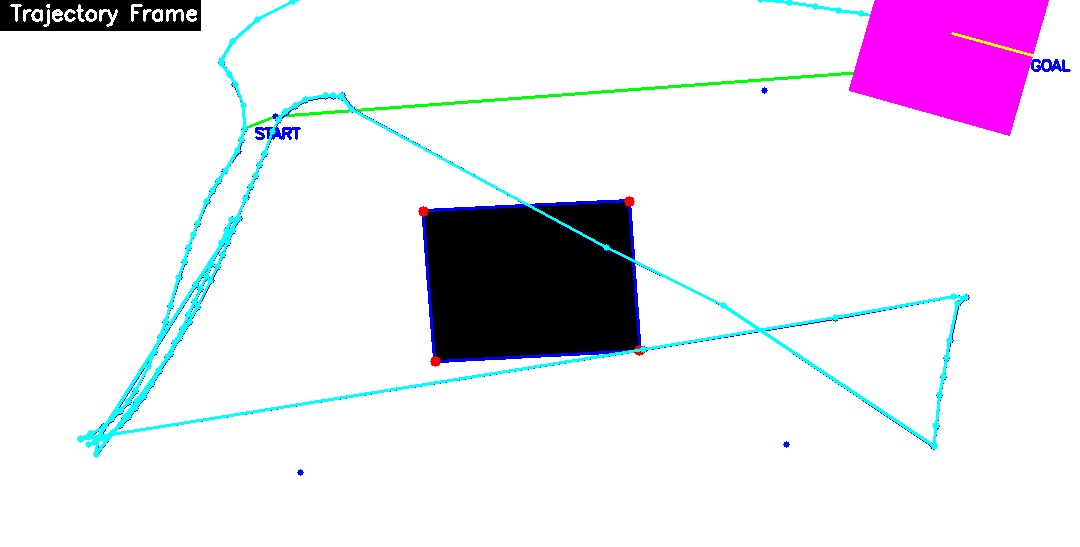

In [9]:
# Display variables
current_frame = None

# Positions variables
thymio_old_pos = thymio_pos
position_measured_history = []
filtered_position_history = [] 

# Flags variables
goal_reached = False

# Control variables
i = 0
covered = 0
left_speed = 0
right_speed = 0

try:
    # Try connecting to the webcam
    print(f"Trying to connect to device {DEVICE_ID}...")
    if not vision.connect_webcam():
        print("Could not find webcam on any device ID. Please check connection.")
        exit(1)
    else: 
        print(f"Successfully connected to device {DEVICE_ID}")
        
    input("Press Enter to start the navigation...")
    
    while not goal_reached:
        i += 1
        
        # Camera Measurement
        _, process_frame = vision.get_frame()
        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
        
        # Odometry Measurement
        left_measured_speed, right_measured_speed = get_speed()
        
        # EKF Prediction step with control inputs
        control_input = np.array([left_speed / SPEED_TO_MM_S, right_speed / SPEED_TO_MM_S])  
        ekf.predict(control_input)
        
        # Get current filtered state
        current_state, _ = ekf.get_state_and_covariance()

        if found_thymio:
            position_measured_history.append(thymio_pos[:2])
            
            # Use camera position and odometry for measurement
            measurement = np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
            if utils.distance(current_state[:2], thymio_old_pos[:2]) > KIDNAP_THRESHOLD:
                found_trajectory = False
                found_thymio = False
                motor_stop()
                
                input("Kidnapped! Press Enter when Thymio has been placed elsewhere...")
                vision.flush()
                while not found_trajectory:
                    while not found_thymio:
                        _, process_frame = vision.get_frame()
                        frame, thymio_pos, found_thymio = vision.get_thymio_position(process_frame)
                        time.sleep(DT)
                    print("Thymio detected!")
                    print(f"Thymio position [mm]: {np.round(thymio_pos[:2], 1)}")
                    print(f"Thymio orientation [°]: {np.degrees(thymio_pos[2])}")
                    
                    trajectory_frame = np.zeros_like(trajectory_frame)
                    trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, thymio_pos, goal_pos, obstacles_pos, 
                                                                                                   THYMIO_WIDTH, vision.scale_factor)
                    current_frame = trajectory_frame.copy()
                    current_frame = utils.draw_trajectory(current_frame, position_measured_history, 
                                                          vision.scale_factor, color=(255, 0, 0))

                    current_frame = utils.draw_trajectory(current_frame, filtered_position_history, 
                                                        vision.scale_factor, color=(255, 255, 0))
                    
                    current_frame = utils.draw_robot(current_frame, thymio_pos, THYMIO_WIDTH, 
                                                     THYMIO_LENGTH, vision.scale_factor)
                    time.sleep(DT)
                    
                current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                                 filtered_position_history, current_state,
                                                                 THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
                    
                # Reinitialize the EKF after kidnapping
                ekf.initialize_state(np.array([thymio_pos[0], thymio_pos[1], thymio_pos[2], 0.0, 0.0]))
                
                # Reset current checkpoint
                local_nav.current_checkpoint = 0
                
                utils.display_frames(None, frame, trajectory_frame)
            
                input("Press Enter to validate the new trajectory...")
                
        else: 
            covered += 1
            # Use filtered position when camera cannot see robot
            measurement = np.array([current_state[0], current_state[1], current_state[2],
                                    left_measured_speed/SPEED_TO_MM_S, right_measured_speed/SPEED_TO_MM_S])
            
        thymio_old_pos = current_state[:3]
        
        # Update EKF with appropriate mode
        ekf.set_mode(covered=(not found_thymio))
        ekf.update(measurement)
        
        # Use filtered state for navigation
        filtered_state, _ = ekf.get_state_and_covariance()
        filtered_position_history.append(filtered_state[:2])
        
        command, goal_reached = local_nav.get_command(trajectory_pos, filtered_state[:3], sensor_data())
        
        if (command['action'] == 'follow_path') or (command['action'] == 'avoid_obstacles'):
            left_speed = command['left_speed']
            right_speed = command['right_speed']
            set_speed(left_speed, right_speed)
            
        elif command['action'] == 'recompute_trajectory': # Recompute trajectory after obstacle avoidance
            found_trajectory = False
            while not found_trajectory:
                _, process_frame = vision.get_frame()
                trajectory_frame = np.zeros_like(trajectory_frame)
                trajectory_frame, trajectory_pos, found_trajectory = global_nav.get_trajectory(obstacles_img, filtered_state[:3], goal_pos, obstacles_pos, 
                                                                                               THYMIO_WIDTH, vision.scale_factor)
                time.sleep(DT)
            current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                             filtered_position_history, current_state,
                                                             THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
            local_nav.current_checkpoint = 0
        else:
            motor_stop()
            
        current_frame = utils.update_visualization_frame(trajectory_frame, position_measured_history, 
                                                         filtered_position_history, current_state,
                                                         THYMIO_WIDTH, THYMIO_LENGTH, vision.scale_factor)
        utils.display_frames(None, process_frame, current_frame) 
        time.sleep(DT)
        
except Exception as e:
    print(f"An error occurred: {str(e)}")
except KeyboardInterrupt:
    print("User interrupted the kernel. Shutting down the motors, closing the webcam...")
finally:
    # Release resources
    vision.disconnect_webcam()
    motor_stop()
    print("Finished at time [s]:", i * DT)
    print("Camera coverage [%]:", covered/i * 100)
    utils.display_frames(None, None, current_frame)
   

In [ ]:

await tdmclient.notebook.stop()
print("Successfully disconnected to Thymio.")

Successfully connected to Thymio.


In [29]:
from IPython.display import clear_output

# Rotation parameters
ANGLE_TOLERANCE = 5 # degrees
KP_ROTATION = 90
MAX_ROTATION_SPEED = 150

# Translation parameters
DISTANCE_TOLERANCE = 50 # mm
KP_TRANSLATION = 0.7 
MIN_TRANSLATION_SPEED = 100
MAX_TRANSLATION_SPEED = 200

# Obstacle avoidance parameters
OBSTACLES_MAX_ITER = 1
OBSTACLES_SPEED = 100
SCALE_SENSOR = 200
WEIGHT_LEFT = [ 5,  8, -10,  -8, -5]
WEIGHT_RIGHT = [-5, -8, -10, 8,  5]


In [40]:
def avoid_obstacles(sensor_data):
    sensor_data = sensor_data[:5]
    print(sensor_data)
    left_speed = 0
    right_speed = 0

    # Updates speed based on sensor data and their corresponding weights
    for i in range(len(sensor_data)):
        left_speed = left_speed + sensor_data[i] * WEIGHT_LEFT[i] / SCALE_SENSOR
        right_speed = right_speed + sensor_data[i] * WEIGHT_RIGHT[i] / SCALE_SENSOR

    command = {
            'action': 'avoid_obstacles',
            'left_speed': int(left_speed + OBSTACLES_SPEED),
            'right_speed': int(right_speed + OBSTACLES_SPEED)
        }
    return command, False

In [41]:
try:
    while 1:
        command, _ = avoid_obstacles(sensor_data())
        print(command)
        v_l = command['left_speed']
        v_r = command['right_speed']
        set_speed(v_l, v_r)
        clear_output(wait=True)
        time.sleep(0.2)
except KeyboardInterrupt:
    print("User interrupted the kernel. Shutting down the motors...")
finally:
    motor_stop()
    print("Motors stopped.")

User interrupted the kernel. Shutting down the motors...
Motors stopped.
